<a href="https://colab.research.google.com/github/GeeksVision/AggressionDetection/blob/master/GeeksVision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#GeeksVision's Code!

##Importing Libraries needed

In [231]:
import glob
import re
# Importing drive method from colab for accessing google drive
from google.colab import drive
%matplotlib inline

## Google Drive Mount

Since we are working on a google colab, we need to mount our personal google drive, only make sure that the shared folder has a shortcut inside the personal drive (annotated by My Drive)

In [3]:
# Mounting drive
# This will require authentication : Follow the steps as guided (to open a shared folder, make a shortcut to it in your drive!)
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Creating categories list from categories folders

In [4]:
# Viewing the data in the folder present from the drive
!ls "/content/drive/My Drive/FacesData"

aggression  neutral


In [5]:
# Save the categories in a categories list
folders = glob.glob("/content/drive/My Drive/FacesData/*")
CATEGORIES = []
for folder in folders:
    cat = re.split('(/)',folder)
    CATEGORIES.append(cat[-1])

In [6]:
CATEGORIES

['aggression', 'neutral']

##Creating Emotions Dataset

In [227]:
import torch
from torch.utils.data import Dataset
import glob
import PIL.Image
import subprocess
import cv2
import os
import uuid
import subprocess
import torchvision
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib

class Emotions_Dataset (Dataset):
    def __init__ (self,directory,categories,Transform=None):
        self.transform=Transform
        self.directory=directory
        self.categories = categories
        self._refresh()

    def __len__ (self):
        return len(self.annotations)

    def __getitem__(self,idx):
        ann = self.annotations[idx]
        image = cv2.imread(ann['image_path'], cv2.IMREAD_COLOR)
        image = PIL.Image.fromarray(image)
        if self.transform is not None:
            image = self.transform(image)
        return image, ann['category_index']
    def _refresh (self):
        self.annotations = []
        for category in self.categories:
            category_index = self.categories.index(category)
            for image_path in glob.glob(os.path.join(self.directory, category, '*.png')):
                self.annotations += [{
                    'image_path': image_path,
                    'category_index': category_index,
                    'category': category
                }]

In [209]:
transform = transforms.Compose(
    [transforms.Resize((32,32)),
    transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [210]:
Emotions = Emotions_Dataset("/content/drive/My Drive/FacesData", CATEGORIES, transform)

In [244]:
image,index=Emotions[67]

In [245]:
image

tensor([[[-0.4431, -0.6706, -0.7176,  ..., -0.3098, -0.1373, -0.1373],
         [-0.5373, -0.7490, -0.7961,  ..., -0.3882, -0.1529, -0.1216],
         [-0.6157, -0.8118, -0.8745,  ..., -0.4745, -0.1686, -0.1137],
         ...,
         [-0.3647, -0.3569, -0.3569,  ..., -0.2627, -0.2471, -0.2549],
         [-0.3804, -0.3725, -0.3647,  ..., -0.2706, -0.2706, -0.2863],
         [-0.3961, -0.3882, -0.3882,  ..., -0.2941, -0.3098, -0.3098]],

        [[-0.4431, -0.6706, -0.7176,  ..., -0.3098, -0.1373, -0.1373],
         [-0.5373, -0.7490, -0.7961,  ..., -0.3882, -0.1529, -0.1216],
         [-0.6157, -0.8118, -0.8745,  ..., -0.4745, -0.1686, -0.1137],
         ...,
         [-0.3647, -0.3569, -0.3569,  ..., -0.2627, -0.2471, -0.2549],
         [-0.3804, -0.3725, -0.3647,  ..., -0.2706, -0.2706, -0.2863],
         [-0.3961, -0.3882, -0.3882,  ..., -0.2941, -0.3098, -0.3098]],

        [[-0.4431, -0.6706, -0.7176,  ..., -0.3098, -0.1373, -0.1373],
         [-0.5373, -0.7490, -0.7961,  ..., -0

In [246]:
CATEGORIES[index]

'aggression'

In [200]:
# imgData = pd.DataFrame([[image, CATEGORIES[index]]], columns=['image', 'category'])

# for i in range(1, len(Emotions)):
#   image, index = Emotions[i]
#   df = pd.DataFrame([[image, CATEGORIES[index]]], columns=['image', 'category'])
#   imgData = imgData.append([df], ignore_index=True)

In [219]:
train_size = int(0.8 * len(Emotions))
test_size = len(Emotions) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(Emotions, [train_size, test_size])

In [222]:
trainloader = torch.utils.data.DataLoader(dataset = train_dataset , batch_size= 64 , 
                                          shuffle = True, num_workers = 2)

testloader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size=4,
                                         shuffle=False, num_workers=2)

In [202]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [203]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [221]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

Finished Training


In [205]:
PATH = './cnn_agg.pth'
torch.save(net.state_dict(), PATH)

TypeError: ignored

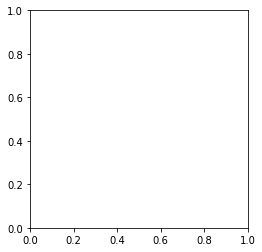

In [242]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
matplotlib.pyplot.imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % CATEGORIES[labels[j]] for j in range(4)))

In [235]:
outputs = net(images)

In [243]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % CATEGORIES[predicted[j]]
                              for j in range(4)))

Predicted:  aggression aggression aggression aggression


In [248]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 60 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 60 test images: 100 %


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

In [ ]:
net.to(device)

In [ ]:
inputs, labels = data[0].to(device), data[1].to(device)